# Journey to Springfield

Предстоит задача научиться классифицировать персонажей проживающих в Спрингфилде.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Загрузка библиотек

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
from PIL import Image

7.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Dec  3 19:20:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим на героев внутри датасета.

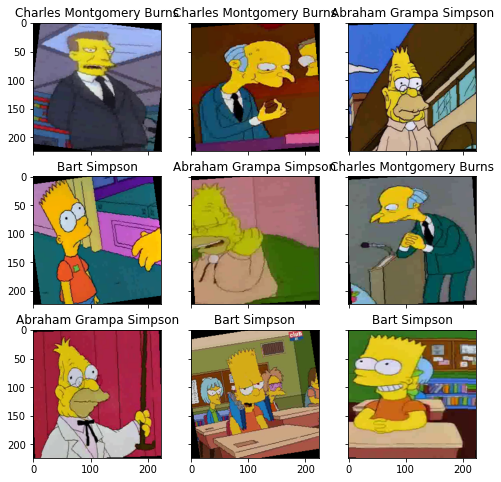

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение простой нейросети

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простой сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    # # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)          
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.10632253285226674


epoch:  50%|█████     | 1/2 [03:16<03:16, 196.39s/it]


Epoch 001 train_loss: 0.1063     val_loss 1.5142 train_acc 0.9651 val_acc 0.7870
loss 0.06967668697157645


epoch: 100%|██████████| 2/2 [06:32<00:00, 196.26s/it]


Epoch 002 train_loss: 0.0697     val_loss 1.5755 train_acc 0.9768 val_acc 0.8003


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

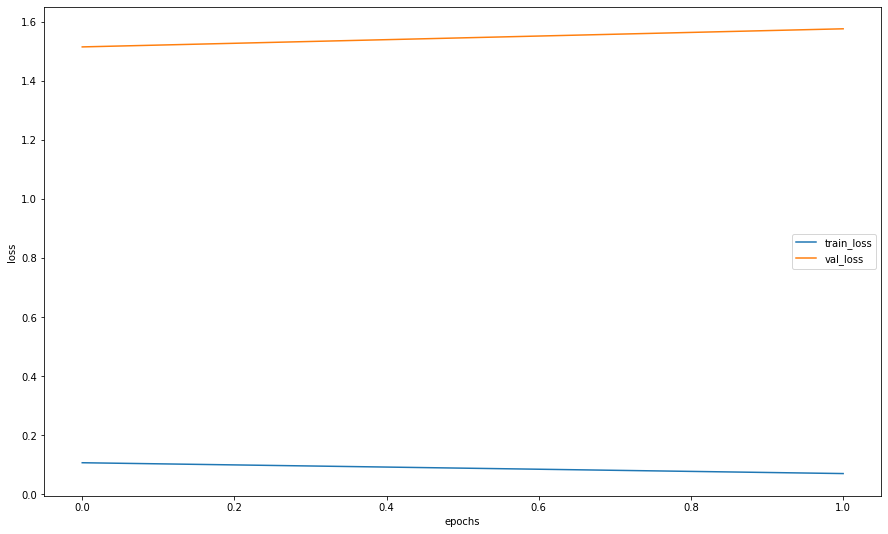

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

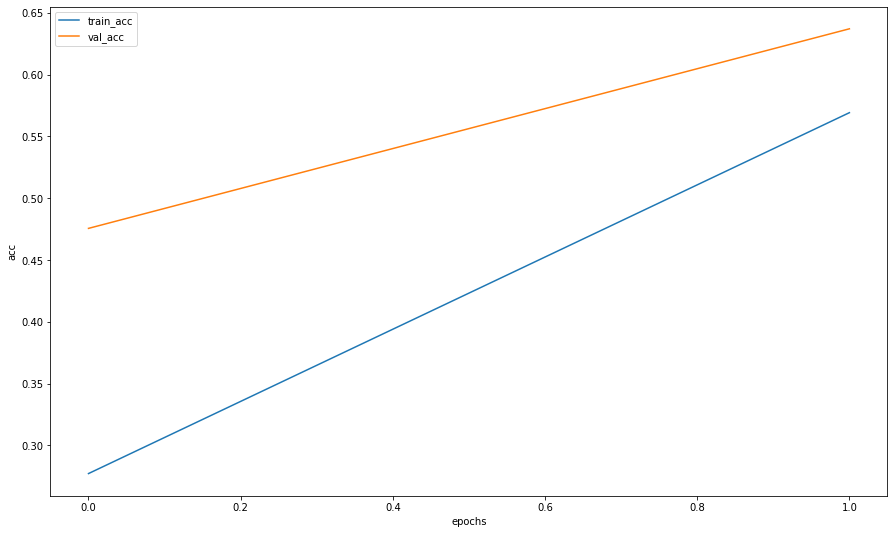

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

 У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred,
         average='micro')

0.55

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

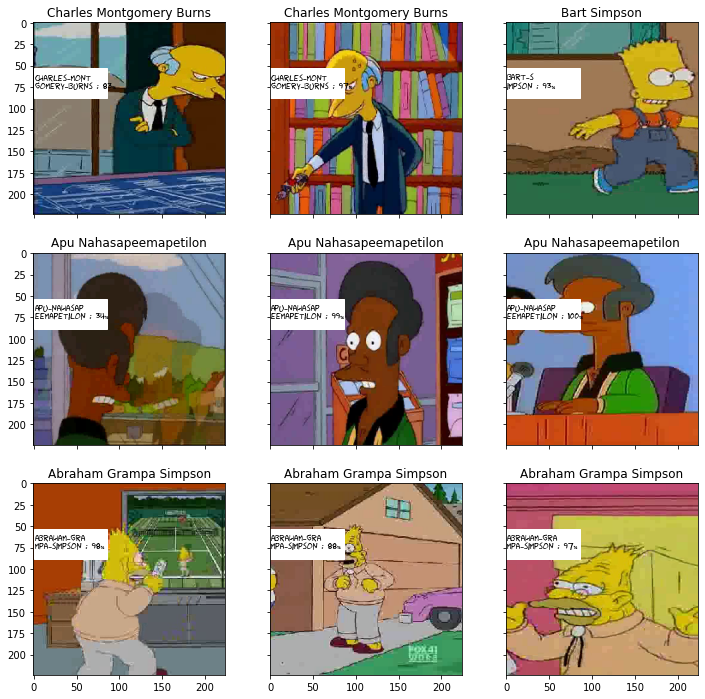

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/MyDrive/simple_cnn_baseline.csv', index=False)

## Pre-trained models

In [ ]:
from torchvision import transforms, models

Загрузим модель ResNet50 предобученную.

In [ ]:
model_resnet50 = models.resnet50(pretrained=True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Посмотрим на архитектуру:

In [ ]:
model_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Заморозим веса, заменим последний классифицирущий слой, в качестве оптимизатора используем Adam

In [ ]:
# замораживаем параметры (веса)
for param in model_resnet50.parameters():
    param.requires_grad = False

# Количество классов
n_classes = len(np.unique(train_val_labels))
# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048

# Заменяем Fully-Connected слой на наш линейный классификатор
model_resnet50.fc = nn.Linear(num_features, n_classes).to(DEVICE)

optimizer = torch.optim.Adam(model_resnet50.fc.parameters(), lr=1e-4)

Зарустим обучение модели

In [ ]:
%%time
history_resnet50 = train(train_dataset, val_dataset, model=model_resnet50, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.5935049596596117


epoch:   5%|▌         | 1/20 [04:46<1:30:46, 286.64s/it]


Epoch 001 train_loss: 0.5935     val_loss 0.6249 train_acc 0.8439 val_acc 0.8359
loss 0.563774157241694


epoch:  10%|█         | 2/20 [09:34<1:26:07, 287.06s/it]


Epoch 002 train_loss: 0.5638     val_loss 0.5964 train_acc 0.8511 val_acc 0.8435
loss 0.5426810820760738


epoch:  15%|█▌        | 3/20 [14:22<1:21:23, 287.29s/it]


Epoch 003 train_loss: 0.5427     val_loss 0.5906 train_acc 0.8538 val_acc 0.8435
loss 0.5287795436567194


epoch:  20%|██        | 4/20 [19:08<1:16:30, 286.91s/it]


Epoch 004 train_loss: 0.5288     val_loss 0.5762 train_acc 0.8599 val_acc 0.8491
loss 0.5126370285438409


epoch:  25%|██▌       | 5/20 [23:55<1:11:43, 286.90s/it]


Epoch 005 train_loss: 0.5126     val_loss 0.5668 train_acc 0.8614 val_acc 0.8485
loss 0.4947176111379287


epoch:  30%|███       | 6/20 [28:40<1:06:50, 286.44s/it]


Epoch 006 train_loss: 0.4947     val_loss 0.5597 train_acc 0.8678 val_acc 0.8519
loss 0.48424581619074136


epoch:  35%|███▌      | 7/20 [33:27<1:02:03, 286.39s/it]


Epoch 007 train_loss: 0.4842     val_loss 0.5476 train_acc 0.8703 val_acc 0.8575
loss 0.4713601368469405


epoch:  40%|████      | 8/20 [38:12<57:13, 286.10s/it]


Epoch 008 train_loss: 0.4714     val_loss 0.5351 train_acc 0.8744 val_acc 0.8580
loss 0.462470842441242


epoch:  45%|████▌     | 9/20 [42:57<52:24, 285.88s/it]


Epoch 009 train_loss: 0.4625     val_loss 0.5472 train_acc 0.8759 val_acc 0.8558
loss 0.451225519499222


epoch:  50%|█████     | 10/20 [47:43<47:39, 285.91s/it]


Epoch 010 train_loss: 0.4512     val_loss 0.5338 train_acc 0.8801 val_acc 0.8569
loss 0.443458938152139


epoch:  55%|█████▌    | 11/20 [52:29<42:52, 285.86s/it]


Epoch 011 train_loss: 0.4435     val_loss 0.5250 train_acc 0.8811 val_acc 0.8621
loss 0.4371293011201598


epoch:  60%|██████    | 12/20 [57:13<38:03, 285.41s/it]


Epoch 012 train_loss: 0.4371     val_loss 0.5111 train_acc 0.8815 val_acc 0.8699
loss 0.4308953441072478


epoch:  65%|██████▌   | 13/20 [1:01:59<33:17, 285.34s/it]


Epoch 013 train_loss: 0.4309     val_loss 0.5053 train_acc 0.8850 val_acc 0.8665
loss 0.42090260898606


epoch:  70%|███████   | 14/20 [1:06:45<28:33, 285.53s/it]


Epoch 014 train_loss: 0.4209     val_loss 0.5229 train_acc 0.8872 val_acc 0.8619
loss 0.41139954096367803


epoch:  75%|███████▌  | 15/20 [1:11:29<23:46, 285.33s/it]


Epoch 015 train_loss: 0.4114     val_loss 0.4903 train_acc 0.8906 val_acc 0.8720
loss 0.4057646963549113


epoch:  80%|████████  | 16/20 [1:16:15<19:01, 285.28s/it]


Epoch 016 train_loss: 0.4058     val_loss 0.4860 train_acc 0.8908 val_acc 0.8737
loss 0.3973042149248833


epoch:  85%|████████▌ | 17/20 [1:21:01<14:16, 285.61s/it]


Epoch 017 train_loss: 0.3973     val_loss 0.4924 train_acc 0.8936 val_acc 0.8733
loss 0.39127248440371365


epoch:  90%|█████████ | 18/20 [1:25:46<09:31, 285.58s/it]


Epoch 018 train_loss: 0.3913     val_loss 0.4955 train_acc 0.8958 val_acc 0.8716
loss 0.383029103412948


epoch:  95%|█████████▌| 19/20 [1:30:31<04:45, 285.33s/it]


Epoch 019 train_loss: 0.3830     val_loss 0.4710 train_acc 0.8969 val_acc 0.8771
loss 0.3821334000799077


epoch: 100%|██████████| 20/20 [1:35:15<00:00, 285.79s/it]


Epoch 020 train_loss: 0.3821     val_loss 0.4764 train_acc 0.8992 val_acc 0.8716
CPU times: user 1h 15min 22s, sys: 19min 54s, total: 1h 35min 16s
Wall time: 1h 35min 15s


In [ ]:
torch.save(model_resnet50.state_dict(), 'Resnet50_fine_tune.pth')

In [ ]:
model_resnet50.load_state_dict(torch.load('Resnet50_fine_tune.pth'))

<All keys matched successfully>

Уменьшим Lr:

In [ ]:
%%time
optimizer = torch.optim.Adam(model_resnet50.fc.parameters(), lr=1e-5)

history_resnet50 = train(train_dataset, val_dataset, model=model_resnet50, epochs=50, batch_size=64)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 1.425480128841891


epoch:   2%|▏         | 1/50 [04:46<3:53:52, 286.39s/it]


Epoch 001 train_loss: 1.4255     val_loss 0.6673 train_acc 0.6427 val_acc 0.8152
loss 0.6629832456735177


epoch:   4%|▍         | 2/50 [09:23<3:46:48, 283.51s/it]


Epoch 002 train_loss: 0.6630     val_loss 0.4372 train_acc 0.8132 val_acc 0.8747
loss 0.33044863553045356


epoch:   6%|▌         | 3/50 [13:59<3:40:21, 281.31s/it]


Epoch 003 train_loss: 0.3304     val_loss 0.3313 train_acc 0.9049 val_acc 0.9098
loss 0.18702166788961047


epoch:   8%|▊         | 4/50 [18:34<3:34:17, 279.50s/it]


Epoch 004 train_loss: 0.1870     val_loss 0.3839 train_acc 0.9459 val_acc 0.9024
loss 0.1396197136879514


epoch:  10%|█         | 5/50 [23:10<3:28:45, 278.34s/it]


Epoch 005 train_loss: 0.1396     val_loss 0.3014 train_acc 0.9584 val_acc 0.9226
loss 0.09036657078458832


epoch:  12%|█▏        | 6/50 [27:45<3:23:25, 277.39s/it]


Epoch 006 train_loss: 0.0904     val_loss 0.3673 train_acc 0.9732 val_acc 0.9177
loss 0.0901724313980742


epoch:  14%|█▍        | 7/50 [32:20<3:18:18, 276.72s/it]


Epoch 007 train_loss: 0.0902     val_loss 0.3476 train_acc 0.9735 val_acc 0.9257
loss 0.05709210052755018


epoch:  16%|█▌        | 8/50 [36:55<3:13:25, 276.32s/it]


Epoch 008 train_loss: 0.0571     val_loss 0.3320 train_acc 0.9827 val_acc 0.9299
loss 0.05092243111129209


epoch:  18%|█▊        | 9/50 [41:31<3:08:36, 276.01s/it]


Epoch 009 train_loss: 0.0509     val_loss 0.3661 train_acc 0.9852 val_acc 0.9119
loss 0.05494228348822205


epoch:  20%|██        | 10/50 [46:06<3:03:52, 275.80s/it]


Epoch 010 train_loss: 0.0549     val_loss 0.4068 train_acc 0.9824 val_acc 0.8991
loss 0.05386030559812276


epoch:  22%|██▏       | 11/50 [50:42<2:59:12, 275.69s/it]


Epoch 011 train_loss: 0.0539     val_loss 0.3436 train_acc 0.9839 val_acc 0.9245
loss 0.04732569712309683


epoch:  24%|██▍       | 12/50 [55:17<2:54:28, 275.48s/it]


Epoch 012 train_loss: 0.0473     val_loss 0.4163 train_acc 0.9857 val_acc 0.9064
loss 0.04966086129181348


epoch:  26%|██▌       | 13/50 [59:52<2:49:48, 275.37s/it]


Epoch 013 train_loss: 0.0497     val_loss 0.3485 train_acc 0.9860 val_acc 0.9282
loss 0.04143037065541837


epoch:  28%|██▊       | 14/50 [1:04:27<2:45:11, 275.31s/it]


Epoch 014 train_loss: 0.0414     val_loss 0.3516 train_acc 0.9880 val_acc 0.9213
loss 0.04502854938842786


epoch:  30%|███       | 15/50 [1:09:01<2:40:26, 275.05s/it]


Epoch 015 train_loss: 0.0450     val_loss 0.3349 train_acc 0.9871 val_acc 0.9264
loss 0.03194219687719203


epoch:  32%|███▏      | 16/50 [1:13:37<2:35:54, 275.14s/it]


Epoch 016 train_loss: 0.0319     val_loss 0.4983 train_acc 0.9913 val_acc 0.9192
loss 0.0356858328797663


epoch:  34%|███▍      | 17/50 [1:18:12<2:31:21, 275.21s/it]


Epoch 017 train_loss: 0.0357     val_loss 0.4284 train_acc 0.9899 val_acc 0.9198
loss 0.060642436555357705


epoch:  36%|███▌      | 18/50 [1:22:47<2:26:43, 275.11s/it]


Epoch 018 train_loss: 0.0606     val_loss 0.3761 train_acc 0.9819 val_acc 0.9131
loss 0.029050256400979847


epoch:  38%|███▊      | 19/50 [1:27:21<2:22:02, 274.92s/it]


Epoch 019 train_loss: 0.0291     val_loss 0.3573 train_acc 0.9915 val_acc 0.9190
loss 0.01989424772138449


epoch:  40%|████      | 20/50 [1:31:56<2:17:25, 274.84s/it]


Epoch 020 train_loss: 0.0199     val_loss 0.4621 train_acc 0.9932 val_acc 0.9209
loss 0.04475500315242216


epoch:  42%|████▏     | 21/50 [1:36:30<2:12:47, 274.73s/it]


Epoch 021 train_loss: 0.0448     val_loss 0.4043 train_acc 0.9868 val_acc 0.9194
loss 0.0266107736412025


epoch:  44%|████▍     | 22/50 [1:41:05<2:08:11, 274.71s/it]


Epoch 022 train_loss: 0.0266     val_loss 0.3946 train_acc 0.9921 val_acc 0.9177
loss 0.024895370917268872


epoch:  46%|████▌     | 23/50 [1:45:39<2:03:31, 274.51s/it]


Epoch 023 train_loss: 0.0249     val_loss 0.4337 train_acc 0.9915 val_acc 0.9251
loss 0.009808416718263097


epoch:  48%|████▊     | 24/50 [1:50:13<1:58:50, 274.25s/it]


Epoch 024 train_loss: 0.0098     val_loss 0.4833 train_acc 0.9975 val_acc 0.9240
loss 0.016432224537950593


epoch:  50%|█████     | 25/50 [1:54:47<1:54:12, 274.11s/it]


Epoch 025 train_loss: 0.0164     val_loss 0.4382 train_acc 0.9951 val_acc 0.9219
loss 0.05578782901513608


epoch:  52%|█████▏    | 26/50 [1:59:20<1:49:32, 273.87s/it]


Epoch 026 train_loss: 0.0558     val_loss 0.4872 train_acc 0.9827 val_acc 0.8903
loss 0.0348757605482287


epoch:  54%|█████▍    | 27/50 [2:03:53<1:44:55, 273.73s/it]


Epoch 027 train_loss: 0.0349     val_loss 0.4618 train_acc 0.9895 val_acc 0.9091
loss 0.031496849845528425


epoch:  56%|█████▌    | 28/50 [2:08:28<1:40:27, 274.00s/it]


Epoch 028 train_loss: 0.0315     val_loss 0.3979 train_acc 0.9910 val_acc 0.9188
loss 0.02092285495087921


epoch:  58%|█████▊    | 29/50 [2:13:06<1:36:16, 275.08s/it]


Epoch 029 train_loss: 0.0209     val_loss 0.6872 train_acc 0.9945 val_acc 0.8854
loss 0.04126727966390846


epoch:  60%|██████    | 30/50 [2:17:42<1:31:49, 275.45s/it]


Epoch 030 train_loss: 0.0413     val_loss 0.5991 train_acc 0.9876 val_acc 0.8978
loss 0.037367425571775505


epoch:  62%|██████▏   | 31/50 [2:22:17<1:27:13, 275.43s/it]


Epoch 031 train_loss: 0.0374     val_loss 0.4452 train_acc 0.9881 val_acc 0.9148
loss 0.027165396438410094


epoch:  64%|██████▍   | 32/50 [2:26:53<1:22:38, 275.48s/it]


Epoch 032 train_loss: 0.0272     val_loss 0.5892 train_acc 0.9918 val_acc 0.9087
loss 0.024060018384189454


epoch:  66%|██████▌   | 33/50 [2:31:31<1:18:16, 276.24s/it]


Epoch 033 train_loss: 0.0241     val_loss 0.4522 train_acc 0.9929 val_acc 0.9236
loss 0.014947725385589576


epoch:  68%|██████▊   | 34/50 [2:36:12<1:14:04, 277.77s/it]


Epoch 034 train_loss: 0.0149     val_loss 0.4820 train_acc 0.9959 val_acc 0.9266
loss 0.019484910829883708


epoch:  70%|███████   | 35/50 [2:40:54<1:09:44, 278.95s/it]


Epoch 035 train_loss: 0.0195     val_loss 0.4949 train_acc 0.9937 val_acc 0.9028
loss 0.02836494214414373


epoch:  72%|███████▏  | 36/50 [2:45:36<1:05:19, 279.95s/it]


Epoch 036 train_loss: 0.0284     val_loss 0.5267 train_acc 0.9917 val_acc 0.9033
loss 0.022642184844536662


epoch:  74%|███████▍  | 37/50 [2:50:13<1:00:27, 279.07s/it]


Epoch 037 train_loss: 0.0226     val_loss 0.4797 train_acc 0.9940 val_acc 0.9089
loss 0.014036799215143213


epoch:  76%|███████▌  | 38/50 [2:54:51<55:43, 278.59s/it]


Epoch 038 train_loss: 0.0140     val_loss 0.5143 train_acc 0.9958 val_acc 0.9056
loss 0.03481998016052359


epoch:  78%|███████▊  | 39/50 [2:59:31<51:08, 278.98s/it]


Epoch 039 train_loss: 0.0348     val_loss 0.5478 train_acc 0.9898 val_acc 0.9068
loss 0.01615163883242617


epoch:  80%|████████  | 40/50 [3:04:09<46:28, 278.88s/it]


Epoch 040 train_loss: 0.0162     val_loss 0.5134 train_acc 0.9948 val_acc 0.9157
loss 0.018942382532938427


epoch:  82%|████████▏ | 41/50 [3:08:47<41:45, 278.44s/it]


Epoch 041 train_loss: 0.0189     val_loss 0.5243 train_acc 0.9943 val_acc 0.9083
loss 0.03819744846297065


epoch:  84%|████████▍ | 42/50 [3:13:26<37:10, 278.86s/it]


Epoch 042 train_loss: 0.0382     val_loss 0.4709 train_acc 0.9889 val_acc 0.9180
loss 0.028347134113501635


epoch:  86%|████████▌ | 43/50 [3:18:06<32:33, 279.05s/it]


Epoch 043 train_loss: 0.0283     val_loss 0.6140 train_acc 0.9913 val_acc 0.8953
loss 0.018769539504377708


epoch:  88%|████████▊ | 44/50 [3:22:47<27:57, 279.56s/it]


Epoch 044 train_loss: 0.0188     val_loss 0.4662 train_acc 0.9943 val_acc 0.9257
loss 0.018998455335450463


epoch:  90%|█████████ | 45/50 [3:27:29<23:21, 280.38s/it]


Epoch 045 train_loss: 0.0190     val_loss 0.5338 train_acc 0.9941 val_acc 0.9117
loss 0.016197025879519173


epoch:  92%|█████████▏| 46/50 [3:32:13<18:45, 281.47s/it]


Epoch 046 train_loss: 0.0162     val_loss 0.5251 train_acc 0.9947 val_acc 0.9089
loss 0.0250190712823849


epoch:  94%|█████████▍| 47/50 [3:36:56<14:05, 281.88s/it]


Epoch 047 train_loss: 0.0250     val_loss 0.5127 train_acc 0.9929 val_acc 0.9089
loss 0.015883319369794514


epoch:  96%|█████████▌| 48/50 [3:41:36<09:22, 281.48s/it]


Epoch 048 train_loss: 0.0159     val_loss 0.4799 train_acc 0.9952 val_acc 0.9217
loss 0.02414056544782525


epoch:  98%|█████████▊| 49/50 [3:46:20<04:42, 282.02s/it]


Epoch 049 train_loss: 0.0241     val_loss 0.5543 train_acc 0.9929 val_acc 0.9039
loss 0.02878007872671352


epoch: 100%|██████████| 50/50 [3:51:02<00:00, 277.26s/it]


Epoch 050 train_loss: 0.0288     val_loss 0.5303 train_acc 0.9918 val_acc 0.9217
CPU times: user 2h 50min 39s, sys: 1h 20s, total: 3h 50min 59s
Wall time: 3h 51min 2s


In [ ]:
torch.save(model_resnet50.state_dict(), '/content/gdrive/MyDrive/resnet50_fine_tune.pth')

In [ ]:
model_resnet50.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet50_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
%%time
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=1e-5)

history_resnet50 = train(train_dataset, val_dataset, model=model_resnet50, epochs=20, batch_size=128)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.24761489453331073


epoch:   5%|▌         | 1/20 [04:54<1:33:13, 294.41s/it]


Epoch 001 train_loss: 0.2476     val_loss 0.2377 train_acc 0.9336 val_acc 0.9371
loss 0.14305596442597596


epoch:  10%|█         | 2/20 [09:39<1:27:29, 291.62s/it]


Epoch 002 train_loss: 0.1431     val_loss 0.1584 train_acc 0.9599 val_acc 0.9593
loss 0.05382175754827636


epoch:  15%|█▌        | 3/20 [14:24<1:22:05, 289.72s/it]


Epoch 003 train_loss: 0.0538     val_loss 0.1703 train_acc 0.9857 val_acc 0.9582
loss 0.03568979191779331


epoch:  20%|██        | 4/20 [19:11<1:17:02, 288.92s/it]


Epoch 004 train_loss: 0.0357     val_loss 0.1863 train_acc 0.9897 val_acc 0.9532
loss 0.04418160374838669


epoch:  25%|██▌       | 5/20 [24:04<1:12:31, 290.11s/it]


Epoch 005 train_loss: 0.0442     val_loss 0.1636 train_acc 0.9864 val_acc 0.9629
loss 0.03143163178719049


epoch:  30%|███       | 6/20 [28:53<1:07:37, 289.84s/it]


Epoch 006 train_loss: 0.0314     val_loss 0.1631 train_acc 0.9908 val_acc 0.9603
loss 0.023614778830681388


epoch:  35%|███▌      | 7/20 [33:44<1:02:50, 290.01s/it]


Epoch 007 train_loss: 0.0236     val_loss 0.1901 train_acc 0.9931 val_acc 0.9597
loss 0.030071883232371505


epoch:  40%|████      | 8/20 [38:30<57:47, 288.92s/it]


Epoch 008 train_loss: 0.0301     val_loss 0.2076 train_acc 0.9903 val_acc 0.9484
loss 0.03684832170843903


epoch:  45%|████▌     | 9/20 [43:13<52:39, 287.19s/it]


Epoch 009 train_loss: 0.0368     val_loss 0.1865 train_acc 0.9882 val_acc 0.9612
loss 0.011862653912896298


epoch:  50%|█████     | 10/20 [47:55<47:36, 285.65s/it]


Epoch 010 train_loss: 0.0119     val_loss 0.2255 train_acc 0.9966 val_acc 0.9509
loss 0.018592178701907842


epoch:  55%|█████▌    | 11/20 [52:38<42:43, 284.82s/it]


Epoch 011 train_loss: 0.0186     val_loss 0.2472 train_acc 0.9945 val_acc 0.9478
loss 0.029291137643132334


epoch:  60%|██████    | 12/20 [57:24<38:01, 285.15s/it]


Epoch 012 train_loss: 0.0293     val_loss 0.1894 train_acc 0.9908 val_acc 0.9585
loss 0.013790099390151984


epoch:  65%|██████▌   | 13/20 [1:02:12<33:22, 286.07s/it]


Epoch 013 train_loss: 0.0138     val_loss 0.2877 train_acc 0.9958 val_acc 0.9392
loss 0.03247922972790056


epoch:  70%|███████   | 14/20 [1:07:02<28:43, 287.23s/it]


Epoch 014 train_loss: 0.0325     val_loss 0.1703 train_acc 0.9901 val_acc 0.9616
loss 0.022206631697680158


epoch:  75%|███████▌  | 15/20 [1:11:53<24:01, 288.27s/it]


Epoch 015 train_loss: 0.0222     val_loss 0.2073 train_acc 0.9938 val_acc 0.9540
loss 0.006132150912699263


epoch:  80%|████████  | 16/20 [1:16:44<19:16, 289.12s/it]


Epoch 016 train_loss: 0.0061     val_loss 0.1629 train_acc 0.9980 val_acc 0.9662
loss 0.012135848520378568


epoch:  85%|████████▌ | 17/20 [1:21:33<14:27, 289.01s/it]


Epoch 017 train_loss: 0.0121     val_loss 0.2284 train_acc 0.9968 val_acc 0.9541
loss 0.022186385330610788


epoch:  90%|█████████ | 18/20 [1:26:22<09:37, 288.98s/it]


Epoch 018 train_loss: 0.0222     val_loss 0.2154 train_acc 0.9934 val_acc 0.9534
loss 0.011057117355261189


epoch:  95%|█████████▌| 19/20 [1:31:11<04:49, 289.14s/it]


Epoch 019 train_loss: 0.0111     val_loss 0.2526 train_acc 0.9970 val_acc 0.9488
loss 0.032622865600713966


epoch: 100%|██████████| 20/20 [1:36:01<00:00, 288.08s/it]


Epoch 020 train_loss: 0.0326     val_loss 0.2184 train_acc 0.9907 val_acc 0.9446
CPU times: user 1h 10min 37s, sys: 25min 23s, total: 1h 36min
Wall time: 1h 36min 1s


In [ ]:
torch.save(model_resnet50.state_dict(), '/content/gdrive/MyDrive/resnet50_fine_tune.pth')

Понизим еще Lr:

In [ ]:
%%time
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=1e-8)

history_resnet50 = train(train_dataset, val_dataset, model=model_resnet50, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.010174596852396117


epoch:  10%|█         | 1/10 [04:38<41:48, 278.75s/it]


Epoch 001 train_loss: 0.0102     val_loss 0.2474 train_acc 0.9971 val_acc 0.9566
loss 0.020308067185375013


epoch:  20%|██        | 2/10 [09:21<37:18, 279.84s/it]


Epoch 002 train_loss: 0.0203     val_loss 0.2119 train_acc 0.9943 val_acc 0.9606
loss 0.005483625380259632


epoch:  30%|███       | 3/10 [14:03<32:43, 280.55s/it]


Epoch 003 train_loss: 0.0055     val_loss 0.1693 train_acc 0.9986 val_acc 0.9650
loss 0.0006133559680570328


epoch:  40%|████      | 4/10 [18:45<28:06, 281.13s/it]


Epoch 004 train_loss: 0.0006     val_loss 0.1428 train_acc 0.9998 val_acc 0.9715
loss 0.00036324403848623284


epoch:  50%|█████     | 5/10 [23:28<23:28, 281.68s/it]


Epoch 005 train_loss: 0.0004     val_loss 0.1351 train_acc 0.9998 val_acc 0.9731
loss 0.0003579657249599424


epoch:  60%|██████    | 6/10 [28:11<18:47, 281.94s/it]


Epoch 006 train_loss: 0.0004     val_loss 0.1363 train_acc 0.9999 val_acc 0.9729
loss 0.0002709411787958134


epoch:  70%|███████   | 7/10 [32:54<14:06, 282.19s/it]


Epoch 007 train_loss: 0.0003     val_loss 0.1406 train_acc 0.9998 val_acc 0.9727
loss 0.00019721462897063843


epoch:  80%|████████  | 8/10 [37:36<09:24, 282.27s/it]


Epoch 008 train_loss: 0.0002     val_loss 0.1452 train_acc 0.9999 val_acc 0.9736
loss 0.00018272143238892848


epoch:  90%|█████████ | 9/10 [42:15<04:41, 281.27s/it]


Epoch 009 train_loss: 0.0002     val_loss 0.1473 train_acc 0.9999 val_acc 0.9736
loss 0.0001313004238066298


epoch: 100%|██████████| 10/10 [46:54<00:00, 281.46s/it]


Epoch 010 train_loss: 0.0001     val_loss 0.1496 train_acc 0.9999 val_acc 0.9746
CPU times: user 33min 24s, sys: 13min 29s, total: 46min 54s
Wall time: 46min 54s


In [ ]:
%%time
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=1e-9)

history_resnet50 = train(train_dataset, val_dataset, model=model_resnet50, epochs=30, batch_size=128)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.174554297093643


epoch:   3%|▎         | 1/30 [05:05<2:27:48, 305.82s/it]


Epoch 001 train_loss: 0.1746     val_loss 0.0595 train_acc 0.9610 val_acc 0.9847
loss 0.02994331515108389


epoch:   7%|▋         | 2/30 [10:03<2:21:33, 303.34s/it]


Epoch 002 train_loss: 0.0299     val_loss 0.0401 train_acc 0.9928 val_acc 0.9883
loss 0.011216037863340718


epoch:  10%|█         | 3/30 [15:00<2:15:37, 301.40s/it]


Epoch 003 train_loss: 0.0112     val_loss 0.0257 train_acc 0.9969 val_acc 0.9922
loss 0.007536839633808466


epoch:  13%|█▎        | 4/30 [19:57<2:10:02, 300.09s/it]


Epoch 004 train_loss: 0.0075     val_loss 0.0541 train_acc 0.9983 val_acc 0.9866
loss 0.0045499972372875066


epoch:  17%|█▋        | 5/30 [24:53<2:04:34, 298.97s/it]


Epoch 005 train_loss: 0.0045     val_loss 0.0283 train_acc 0.9990 val_acc 0.9927
loss 0.004189673027320024


epoch:  20%|██        | 6/30 [29:51<1:59:26, 298.62s/it]


Epoch 006 train_loss: 0.0042     val_loss 0.0227 train_acc 0.9992 val_acc 0.9939
loss 0.0015524090857284064


epoch:  23%|██▎       | 7/30 [34:47<1:54:08, 297.76s/it]


Epoch 007 train_loss: 0.0016     val_loss 0.0179 train_acc 0.9997 val_acc 0.9952
loss 0.0008391407730497376


epoch:  27%|██▋       | 8/30 [39:43<1:48:59, 297.23s/it]


Epoch 008 train_loss: 0.0008     val_loss 0.0174 train_acc 0.9996 val_acc 0.9948
loss 0.0005353161550840715


epoch:  30%|███       | 9/30 [44:40<1:44:03, 297.33s/it]


Epoch 009 train_loss: 0.0005     val_loss 0.0174 train_acc 0.9998 val_acc 0.9952
loss 0.0006567862540537104


epoch:  33%|███▎      | 10/30 [49:37<1:39:02, 297.11s/it]


Epoch 010 train_loss: 0.0007     val_loss 0.0175 train_acc 0.9997 val_acc 0.9948
loss 0.0005064077244808311


epoch:  37%|███▋      | 11/30 [54:33<1:34:02, 296.96s/it]


Epoch 011 train_loss: 0.0005     val_loss 0.0213 train_acc 0.9998 val_acc 0.9947
loss 0.07728077165491587


epoch:  40%|████      | 12/30 [59:29<1:28:57, 296.54s/it]


Epoch 012 train_loss: 0.0773     val_loss 0.0540 train_acc 0.9792 val_acc 0.9836
loss 0.023447469818869183


epoch:  43%|████▎     | 13/30 [1:04:25<1:23:59, 296.42s/it]


Epoch 013 train_loss: 0.0234     val_loss 0.0520 train_acc 0.9929 val_acc 0.9849
loss 0.01951079731540749


epoch:  47%|████▋     | 14/30 [1:09:21<1:18:58, 296.19s/it]


Epoch 014 train_loss: 0.0195     val_loss 0.0288 train_acc 0.9944 val_acc 0.9908
loss 0.011051076929986617


epoch:  50%|█████     | 15/30 [1:14:17<1:14:01, 296.07s/it]


Epoch 015 train_loss: 0.0111     val_loss 0.0315 train_acc 0.9969 val_acc 0.9903
loss 0.004583544224530924


epoch:  53%|█████▎    | 16/30 [1:19:13<1:09:05, 296.09s/it]


Epoch 016 train_loss: 0.0046     val_loss 0.0223 train_acc 0.9989 val_acc 0.9929
loss 0.0008422047310657026


epoch:  57%|█████▋    | 17/30 [1:24:08<1:04:06, 295.92s/it]


Epoch 017 train_loss: 0.0008     val_loss 0.0170 train_acc 0.9997 val_acc 0.9958
loss 0.0003955553635774118


epoch:  60%|██████    | 18/30 [1:29:04<59:10, 295.88s/it]


Epoch 018 train_loss: 0.0004     val_loss 0.0175 train_acc 0.9999 val_acc 0.9958
loss 0.0003314616944313729


epoch:  63%|██████▎   | 19/30 [1:34:00<54:14, 295.87s/it]


Epoch 019 train_loss: 0.0003     val_loss 0.0173 train_acc 0.9999 val_acc 0.9958
loss 0.00046095624734849444


epoch:  67%|██████▋   | 20/30 [1:38:56<49:18, 295.86s/it]


Epoch 020 train_loss: 0.0005     val_loss 0.0172 train_acc 0.9998 val_acc 0.9960
loss 0.0003455712195400517


epoch:  70%|███████   | 21/30 [1:43:52<44:23, 295.90s/it]


Epoch 021 train_loss: 0.0003     val_loss 0.0179 train_acc 0.9999 val_acc 0.9956
loss 0.00045424460239939775


epoch:  73%|███████▎  | 22/30 [1:48:52<39:37, 297.18s/it]


Epoch 022 train_loss: 0.0005     val_loss 0.0178 train_acc 0.9998 val_acc 0.9956
loss 0.00031346451984454426


epoch:  77%|███████▋  | 23/30 [1:53:51<34:45, 297.88s/it]


Epoch 023 train_loss: 0.0003     val_loss 0.0174 train_acc 0.9999 val_acc 0.9960
loss 0.00035364192214523135


epoch:  80%|████████  | 24/30 [1:58:45<29:39, 296.59s/it]


Epoch 024 train_loss: 0.0004     val_loss 0.0174 train_acc 0.9998 val_acc 0.9958
loss 0.00039811422274496053


epoch:  83%|████████▎ | 25/30 [2:03:37<24:35, 295.20s/it]


Epoch 025 train_loss: 0.0004     val_loss 0.0175 train_acc 0.9997 val_acc 0.9958
loss 0.00033753919236065305


epoch:  87%|████████▋ | 26/30 [2:08:28<19:35, 293.92s/it]


Epoch 026 train_loss: 0.0003     val_loss 0.0179 train_acc 0.9999 val_acc 0.9950
loss 0.00034092587339282167


epoch:  90%|█████████ | 27/30 [2:13:18<14:38, 292.68s/it]


Epoch 027 train_loss: 0.0003     val_loss 0.0175 train_acc 0.9998 val_acc 0.9958
loss 0.00033627334456100706


epoch:  93%|█████████▎| 28/30 [2:18:10<09:44, 292.45s/it]


Epoch 028 train_loss: 0.0003     val_loss 0.0178 train_acc 0.9997 val_acc 0.9956
loss 0.00029264323990406253


epoch:  97%|█████████▋| 29/30 [2:23:02<04:52, 292.30s/it]


Epoch 029 train_loss: 0.0003     val_loss 0.0180 train_acc 0.9999 val_acc 0.9954
loss 0.0003310258687367875


epoch: 100%|██████████| 30/30 [2:27:53<00:00, 295.77s/it]


Epoch 030 train_loss: 0.0003     val_loss 0.0173 train_acc 0.9998 val_acc 0.9956
CPU times: user 1h 47min 33s, sys: 40min 16s, total: 2h 27min 50s
Wall time: 2h 27min 53s


In [ ]:
torch.save(model_resnet50.state_dict(), '/content/gdrive/MyDrive/resnet50_fine_tune.pth')

Делаем предсказание:

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)
my_submit.to_csv('gdrive/MyDrive/resnet50_predict_3.csv', index=False)